In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras_ocr

# get scale

In [100]:

scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))

gs_scale_image = scale_image.convert("L")

grayscale_array = np.array(gs_scale_image)

def get_scale(array):
    array = np.array([x[0] for x in array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)
    return scale

scale = get_scale(grayscale_array)

In [108]:
scale

[46,
 45,
 49,
 54,
 55,
 56,
 60,
 62,
 63,
 64,
 67,
 68,
 70,
 71,
 74,
 75,
 76,
 79,
 80,
 81,
 82,
 83,
 87,
 89,
 88,
 92,
 95,
 96,
 99,
 101,
 103,
 102,
 104,
 106,
 108,
 109,
 110,
 111,
 112,
 115,
 117,
 119,
 118,
 121,
 122,
 124,
 123,
 126,
 129,
 130,
 131,
 132,
 136,
 138,
 139,
 140,
 143,
 146,
 147,
 150,
 153,
 154,
 155,
 157,
 158,
 160,
 162,
 161,
 163,
 167,
 169,
 170,
 173,
 177,
 178,
 181,
 185,
 186,
 184,
 189,
 191,
 195,
 193,
 194,
 199,
 203,
 202,
 204,
 209,
 213,
 212,
 211,
 208,
 205,
 201,
 197,
 196,
 192,
 188,
 187,
 183,
 180,
 179,
 176,
 175,
 174,
 172,
 171,
 168,
 166,
 165,
 156,
 151,
 141,
 142,
 107,
 100,
 94,
 93,
 91,
 86,
 85,
 84,
 78,
 77,
 73,
 72,
 69,
 66,
 65,
 61,
 59,
 58,
 53]

In [109]:
def get_scale(ID):

    scale_image = Image.open(os.path.join('inputs\scales', ID +'.png'))
    gs_scale_image = scale_image.convert("L")
    grayscale_array = np.array(gs_scale_image)


    array = np.array([x[0] for x in grayscale_array])
    seen = set()
    scale = []
    for i in array:
        if i not in seen:
            seen.add(i)
            scale.append(i)

    return scale

# get efficiency map

In [101]:
# infill text using ocr

def infill_text(ID):

    def midpoint(x1, y1, x2, y2):
        x_mid = int((x1 + x2)/2)
        y_mid = int((y1 + y2)/2)
        return (x_mid, y_mid)

    pipeline = keras_ocr.pipeline.Pipeline()

    img = keras_ocr.tools.read(os.path.join('inputs\efficiency_maps', ID +'.png'))

    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")
    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255,    
        thickness)
        img = cv2.inpaint(img, mask, 7, cv2.INPAINT_NS)
                    
    return(img)

In [102]:
def infill_lines(im):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    edges = cv2.Canny(gray, 50, 150)

    # Create a mask by dilating the edges
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.dilate(edges, kernel, iterations=1)

    nolines = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)

    return nolines

In [113]:
def infill_not_in_scale(im, scale):

    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    _additional_gs = [250,251,252,253,254,255] # these are black or close to black

    # Define the predefined list of grayscale values
    scale += _additional_gs

    mask = np.ones_like(gray) * 255  # Initialize mask with all white pixels
    for value in scale:
        mask[gray == value] = 0  # Set pixels with predefined grayscale values to black in the mask

    inscale = cv2.inpaint(im, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

    return inscale

In [119]:
#ID = 'HDSRM300'
#ID = 'YASA_P400'
ID = '180-100-009'

In [120]:
scale = get_scale(ID)
em = infill_text(ID)
nolines = infill_lines(em)
inscale = infill_not_in_scale(nolines, scale)

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


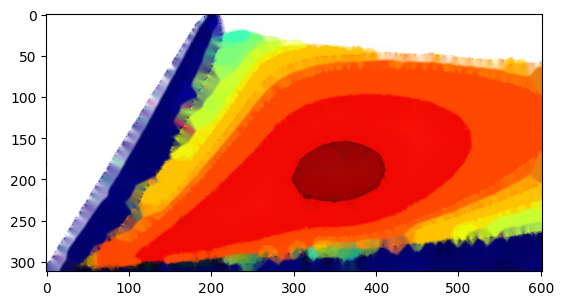

In [121]:
plt.imshow(inscale)

In [122]:
def preprocess(ID):
    scale = get_scale(ID)
    em = infill_text(ID)
    nolines = infill_lines(em)
    processed_img = infill_not_in_scale(nolines, scale)

    return processed_img

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


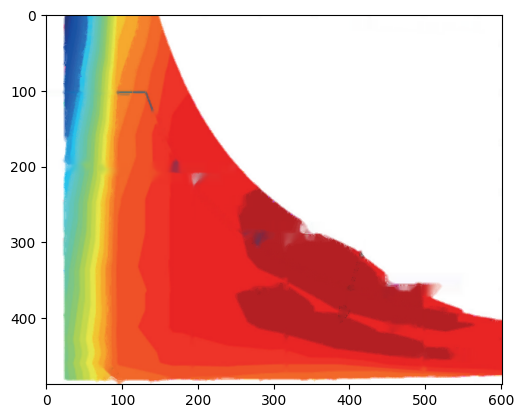

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 3s 3s/step


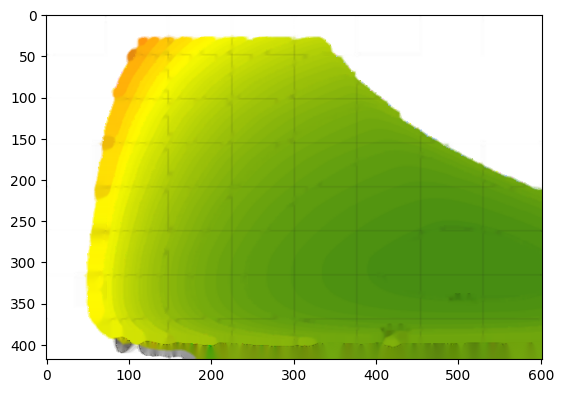

Looking for C:\Users\benst\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\benst\.keras-ocr\crnn_kurapan.h5
1/1 [==============================] - 4s 4s/step


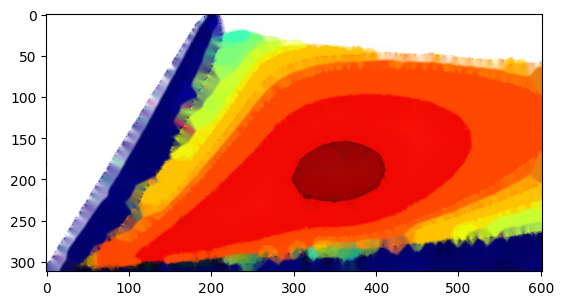

In [124]:
IDS = ['HDSRM300', 'YASA_P400', '180-100-009']
for ID in IDS:
    plt.show()
    processed_img = preprocess(ID)
    plt.imshow(processed_img)

In [ ]:
## notes
# make initial cropping etc part of a ui tool
# use cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) to grayscale instead of PIL
# the two black list may need some work